# German rent estimation

This notebook aims to train a predictor for estimating the rent of the german properties.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
import pickle

from sklearn import datasets, ensemble
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from catboost import CatBoostRegressor
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import HashingVectorizer
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
# Random Seed at file level
random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
def check_missing_rate(data: pd.DataFrame) -> pd.DataFrame:
    "A function to calculate missing value rates"
    total = data.isnull().sum()
    percent = ((data.isnull().sum()/data.shape[0])*100)
    types = data.dtypes
    filter_info = pd.concat([total, percent, types], axis=1, keys=['No_Missing_Values', 'Percent', 'Types'])
    filter_info.sort_values(by=['Percent'], ascending=False)
    return filter_info

In [4]:
# Load data
DATA_PATH = '../data/immo_data.csv'
apartment_data_raw = pd.read_csv(DATA_PATH, header=0)

## EDA and Data Preprocessing

In [5]:
# Drop duplicates if any
apartment_data_raw.drop_duplicates(inplace=True)

In [6]:
# Get some info from data
apartment_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [7]:
# Take a look at data
apartment_data_raw.head(10)

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.00,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.00,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.00,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.00,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.00,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.00,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.00,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.00,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20
5,Schleswig_Holstein,142.00,gas_heating,NONE,NaN,False,True,5,4.48,2.4,NaN,1999.0,115531145,NaN,gas,True,Schleswig_Holstein,False,5.0,315.20,1e,53.43,Schleswig_Flensburg_Kreis,well_kept,NaN,no,Hardeseiche,Hardeseiche,False,2,apartment,24891,2.0,165.0,NaN,NaN,2,False,2,Schleswig_Flensburg_Kreis,Struxdorf,NaN,"helle ebenerdige 2 Zi. Wohnung mit Terrasse, h...",NaN,NaN,NaN,NaN,NaN,Feb20
6,Sachsen,70.00,self_contained_central_heating,ONE_YEAR_FREE,10.0,False,False,9,1.01,2.4,380.00,NaN,114391930,NaN,NaN,False,Sachsen,True,NaN,310.00,14,62.00,Mittelsachsen_Kreis,fully_renovated,NaN,NaN,Am Bahnhof,Am_Bahnhof,False,2,NaN,9599,2.0,NaN,1.0,4.0,2,True,3,Mittelsachsen_Kreis,Freiberg,Am Bahnhof 14 in Freiberg\nHeizkosten und Warm...,NaN,NaN,NaN,NaN,NaN,NaN,Feb20
7,Bremen,88.00,central_heating,ONE_YEAR_FREE,10.0,False,True,5,1.89,2.4,584.25,1959.0,115270775,NaN,gas:electricity,False,Bremen,True,2.0,452.25,35,60.30,Bremen,NaN,NaN,NaN,Lesumer Heerstr.,Lesumer_Heerstr.,False,3,ground_floor,28717,3.0,63.0,NaN,NaN,3,False,2,Bremen,St._Magnus,+ Komfortabler Bodenbelag: Die Wohnung ist zus...,Rollläden; Warmwasserbereiter; Kellerraum; Gas...,44.00,B,NaN,NaN,NaN,Feb20
8,Baden_Württemberg,110.00,oil_heating,ONE_YEAR_FREE,NaN,False,False,5,3.77,40.0,690.00,1970.0,106416361,1.0,oil,True,Baden_Württemberg,True,2.0,580.00,NaN,53.00,Emmen

In [8]:
# Take look at some statistics from the data
apartment_data_raw.describe(include='all')

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
count,268850,261941.000000,223994,236231,45020.0,268850,268850,268850.000000,267018.000000,235492.000000,2.283330e+05,211805.000000,2.688500e+05,93052.000000,211886,268850,268850,268850,211805.000000,2.688500e+05,197832,268850.000000,268850,200361,156185,154277,268850,197837,268850,268850.000000,232236,268850.000000,268850.000000,162344.000000,217541.000000,171118.000000,268850.000000,268850,268850.000000,268850,268850,249103,215926,85518.000000,77787,80711.000000,46846.000000,46846.000000,268850
unique,16,NaN,13,3,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132,2,16,2,NaN,NaN,5510,NaN,419,10,4,3,52373,54490,2,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,419,8684,212621,189526,NaN,10,NaN,NaN,NaN,4
top,Nordrhein_Westfalen,NaN,central_heating,ONE_YEAR_FREE,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas,False,Nordrhein_Westfalen,True,NaN,NaN,1,NaN,Leipzig,well_kept,normal,negotiable,no_information,Hauptstraße,False,NaN,apartment,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Leipzig,Innenstadt,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat,NaN,C,NaN,NaN,NaN,Feb20
freq,62863,NaN,128977,227632,NaN,247679,165734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110899,176794,62863,172235,NaN,NaN,7173,NaN,13723,66591,81826,91970,71013,911,205528,NaN,131522,NaN,NaN,NaN,NaN,NaN,NaN,216093,NaN,13723,4751,216,207,NaN,14613,NaN,NaN,NaN,79276
mean,NaN,151.206113,NaN,NaN,10.0,NaN,NaN,9.791958,3.389001,28.804928,9.013315e+02,1966.400590,1.069697e+08,1.327634,NaN,NaN,NaN,NaN,3.714544,6.941294e+02,NaN,74.355548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.765256,NaN,37283.022235,2.641261,114.749533,2.122405,3.572319,2.571542,NaN,3.070790,NaN,NaN,NaN,NaN,76.990866,NaN,2013.904536,89.113612,0.199769,NaN
std,NaN,308.295790,NaN,NaN,0.0,NaN,NaN,6.408399,1.964874,16.337151,3.323833e+04,46.992207,1.250093e+07,8.361403,NaN,NaN,NaN,NaN,2.738134,1.953602e+04,NaN,254.759208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.214357,NaN,27798.037296,2.633440,61.653663,3.634934,6.375496,0.937594,NaN,1.407127,NaN,NaN,NaN,NaN,147.716278,NaN,10.963125,5.395805,0.009667,NaN
min,NaN,0.000000,NaN,NaN,10.0,NaN,NaN,0.000000,-12.330000,1.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,NaN,NaN,NaN,NaN,1.000000,0.000000e+00,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,852.000000,1.000000,0.100000,-1.000000,0.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,1015.000000,71.430000,0.170500,NaN
25%,NaN,95.000000,NaN,NaN,10.0,NaN,NaN,6.000000,2.000000,10.000000,4.698000e+02,1950.000000,1.066910e+08,1.000000,NaN,NaN,NaN,NaN,1.000000,3.380000e+02,NaN,54.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,9128.000000,2.000000,79.000000,1.000000,2.000000,2.000000,NaN,2.000000,NaN,NaN,NaN,NaN,54.000000,NaN,2012.000000,90.760000,0.191500,NaN
50%,NaN,135.000000,NaN,NaN,10.0,NaN,NaN,9.000000,3.390000,40.000000,6.500000e+02,1973.000000,1.111584e+08,1.000000,NaN,NaN,NaN,NaN,3.000000,4.900000e+02,NaN,67.320000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,38667.000000,3.000000,107.000000,2.000000,3.000000,3.000000,NaN,3.000000,NaN,NaN,NaN,NaN,70.000000,NaN,2017.000000,90.760000,0.198500,NaN
75%,NaN,190.000000,NaN,NaN,10.0,NaN,NaN,13.000000,4.570000,40.000000,9.850000e+02,1996.000000,1.137688e+08,1.000000,NaN,NaN,NaN,NaN,5.000000,7.990000e+02,NaN,87.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,57072.000000,3.000000,140.300000,3.000000,4.000000,3.000000,NaN,4.000000,NaN,NaN,NaN,NaN,90.000000,NaN,2019.000000,90.760000,0.205500,NaN


In [9]:
# Uncomment below to do some profiling
# profile_apartment_raw = ProfileReport(apartment_data_raw, title="Profiling Report Raw Data")

In [10]:
# Profiling takes time save it for future reference
# profile_apartment_raw.to_file("apartment_profile.html")

In [11]:
# Take a look at the profile of the data
# profile_apartment_raw

In [12]:
# After reviwing the profile, the scoutId is dropped since it has nothing to do with the rent amount
apartment_data_raw.drop(columns=['scoutId'], inplace=True)

In [13]:
# Check whether there is linear correlation between features
apartment_data_raw.corr(numeric_only=True)

,serviceCharge,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,lift,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
serviceCharge,1.000000,NaN,0.047680,0.060859,0.061569,0.063738,0.010687,0.003954,0.032162,0.005239,0.039271,0.019692,0.064502,0.236240,0.076134,0.074333,0.170721,0.038231,0.051044,-0.019583,0.002058,0.007053,0.135221,0.013835,0.188643,0.059051,0.012926,0.032762,-0.099237
telekomHybridUploadSpeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
newlyConst,0.047680,NaN,1.000000,0.148819,0.024229,0.151364,0.022647,0.003579,0.370771,0.004011,0.043390,-0.004113,0.643279,0.006022,0.016984,0.323874,0.316112,0.084787,0.025642,-0.285302,-0.014554,-0.000037,0.077723,0.003740,0.161220,0.043852,0.093243,-0.033352,-0.047560
balcony,0.060859,NaN,0.148819,1.000000,0.118522,0.109731,0.013752,0.005945,0.270167,-0.000284,0.076179,0.174154,0.281383,0.003796,0.027546,0.214250,0.302079,0.084672,0.070366,-0.179097,0.006623,0.023792,0.203371,0.008642,0.254343,0.038210,0.068632,0.002004,-0.080837
picturecount,0.061569,NaN,0.024229,0.118522,1.000000,0.113967,0.008099,0.006874,0.008973,0.002356,0.152019,0.051115,0.077407,0.004449,0.034586,0.090773,0.307180,0.024755,0.068663,-0.055098,-0.001080,-0.002851,0.186509,0.109193,0.279490,0.073781,0.069856,0.037609,-0.040303
pricetrend,0.063738,NaN,0.151364,0.109731,0.113967,1.000000,0.034414,0.008578,0.133513,0.008071,0.248672,-0.041740,0.213652,0.012010,0.022749,0.197293,0.513047,0.279818,0.013048,0.002473,0.011927,0.023203,0.024270,-0.044821,0.166392,0.027388,0.176206,0.000636,-0.163768
telekomUploadSpeed,0.010687,NaN,0.022647,0.013752,0.008099,0.034414,1.000000,0.001621,-0.025394,-0.010341,-0.014182,0.025151,-0.018838,-0.000183,-0.002528,0.015317,0.020725,-0.027074,-0.004439,0.002748,0.003404,0.007569,-0.008828,-0.007548,-0.012895,0.000859,0.007396,0.014317,-0.033121
totalRent,0.003954,NaN,0.003579,0.005945,0.006874,0.008578,0.001621,1.000000,0.005034,0.001753,0.002727,0.001267,0.009112,0.101741,0.001831,0.008710,0.018058,0.006944,0.005255,-0.004417,0.000202,-0.000117,0.009138,-0.000476,0.016085,0.126509,0.016373,0.004596,-0.015181
yearConstructed,0.032162,NaN,0.370771,0.270167,0.008973,0.133513,-0.025394,0.005034,1.000000,0.010251,0.094855,0.025910,0.741020,0.152298,0.015492,0.299725,0.222805,0.183667,0.013223,-0.319186,0.015912,0.014524,0.033920,-0.053364,0.082862,0.010064,0.130042,-0.075397,-0.082245
noParkSpaces,0.005239,NaN,0.004011,-0.000284,0.002356,0.008071,-0.010341,0.001753,0.010251,1.000000,0.003894,-0.002933,0.011564,0.009466,0.000420,0.016697,-0.001555,-0.007366,0.006314,-0.008079,0.003278,0.005390,-0.005555,-0.002808,-0.001338,-0.001284,0.013365,-0.000785,-0.000422


<Axes: >

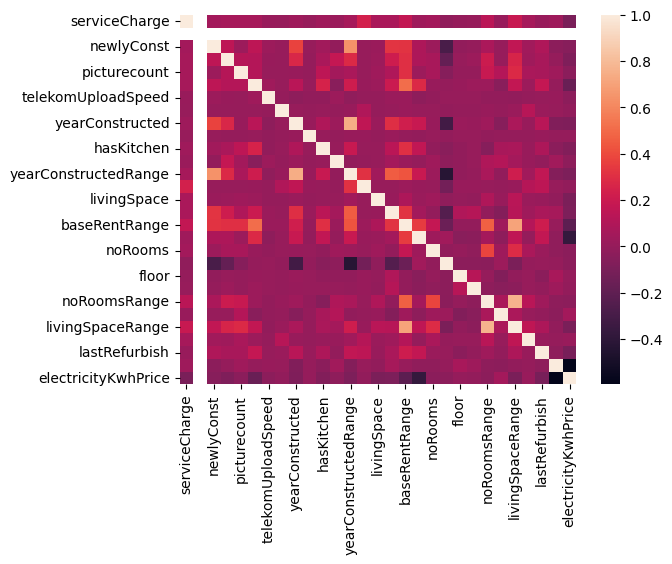

In [14]:
# Draw correlation as a heatmap
sns.heatmap(apartment_data_raw.corr(numeric_only=True))

In [15]:
# Look at the missing data
missing_values_info_df = check_missing_rate(apartment_data_raw)
missing_values_info_df.sort_values(by=['Percent'], ascending=False)

,No_Missing_Values,Percent,Types
telekomHybridUploadSpeed,223830,83.254603,float64
electricityKwhPrice,222004,82.575414,float64
electricityBasePrice,222004,82.575414,float64
energyEfficiencyClass,191063,71.066766,object
lastRefurbish,188139,69.979171,float64
heatingCosts,183332,68.191185,float64
noParkSpaces,175798,65.388879,float64
petsAllowed,114573,42.615957,object
interiorQual,112665,41.906267,object
thermalChar,106506,39.615399,float64


In [16]:
# Looking on the missing values I decided to remove the columns with missing values higher than 25.5 %
apartment_data_raw = apartment_data_raw.drop((missing_values_info_df[missing_values_info_df['Percent'] > 26]).index, axis=1)

In [17]:
# Look again after dropping some columns
filtered_missing_values_info_df = check_missing_rate(apartment_data_raw)
filtered_missing_values_info_df.sort_values(by=['Percent'], ascending=False)

,No_Missing_Values,Percent,Types
condition,68489,25.474800,object
yearConstructed,57045,21.218151,float64
yearConstructedRange,57045,21.218151,float64
firingTypes,56964,21.188023,object
facilities,52924,19.685326,object
floor,51309,19.084620,float64
heatingType,44856,16.684397,object
totalRent,40517,15.070485,float64
typeOfFlat,36614,13.618747,object
telekomUploadSpeed,33358,12.407662,float64


In [18]:
# totalRent and baseRent will be the predicted outputs, take them out
totalRent = apartment_data_raw.totalRent.copy(deep=True)
baseRent = apartment_data_raw.baseRent.copy(deep=True)
# facilities and descriptions will be used later, take them out
facilities = apartment_data_raw.facilities.copy(deep=True)
description = apartment_data_raw.description.copy(deep=True)

In [19]:
# geo_bln is the same as regio1
# geo_krs is the same as regio2
# facilities and descriptions will be processed separately
# data and street are also excludede
apartment_data_raw.drop(columns=['totalRent', 'baseRent', 'date', 'geo_bln', 'geo_krs', 'facilities', 'description', 'street'], inplace=True)
apartment_data_raw.head(n=10)

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,yearConstructed,firingTypes,hasKitchen,cellar,yearConstructedRange,livingSpace,condition,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,floor,noRoomsRange,garden,livingSpaceRange,regio2,regio3
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,False,False,6,4.62,10.0,1965.0,oil,False,True,2.0,86.00,well_kept,False,4,ground_floor,44269,4.0,1.0,4,True,4,Dortmund,Schüren
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,False,True,8,3.47,10.0,1871.0,gas,False,False,1.0,89.00,refurbished,False,5,ground_floor,67459,3.0,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,True,True,8,2.72,2.4,2019.0,NaN,False,True,9.0,83.80,first_time_use,True,6,apartment,1097,3.0,3.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,False,True,9,1.53,40.0,1964.0,district_heating,False,False,2.0,58.15,NaN,False,2,other,9599,3.0,3.0,3,False,2,Mittelsachsen_Kreis,Freiberg
4,Bremen,138.00,self_contained_central_heating,NaN,False,True,19,2.46,NaN,1950.0,gas,False,False,1.0,84.97,refurbished,False,5,apartment,28213,3.0,1.0,3,False,4,Bremen,Neu_Schwachhausen
5,Schleswig_Holstein,142.00,gas_heating,NONE,False,True,5,4.48,2.4,1999.0,gas,True,False,5.0,53.43,well_kept,False,2,apartment,24891,2.0,NaN,2,False,2,Schleswig_Flensburg_Kreis,Struxdorf
6,Sachsen,70.00,self_contained_central_heating,ONE_YEAR_FREE,False,False,9,1.01,2.4,NaN,NaN,False,True,NaN,62.00,fully_renovated,False,2,NaN,9599,2.0,1.0,2,True,3,Mittelsachsen_Kreis,Freiberg
7,Bremen,88.00,central_heating,ONE_YEAR_FREE,False,True,5,1.89,2.4,1959.0,gas:electricity,False,True,2.0,60.30,NaN,False,3,ground_floor,28717,3.0,NaN,3,False,2,Bremen,St._Magnus
8,Baden_Württemberg,110.00,oil_heating,ONE_YEAR_FREE,False,False,5,3.77,40.0,1970.0,oil,True,True,2.0,53.00,well_kept,False,4,roof_storey,79211,2.0,2.0,2,False,2,Emmendingen_Kreis,Denzlingen
9,Nordrhein_Westfalen,95.00,self_contained_central_heating,ONE_YEAR_FREE,False,False,7,1.92,40.0,1953.0,gas,False,True,2.0,60.00,well_kept,False,1,apartment,45888,2.5,2.0,2,False,2,Gelsenkirchen,Bulmke_Hüllen


In [20]:
# Look at data again after dropping some other columns
missing_values_info_df = check_missing_rate(apartment_data_raw)
missing_values_info_df.sort_values(by=['Percent'], ascending=False)

,No_Missing_Values,Percent,Types
condition,68489,25.474800,object
yearConstructedRange,57045,21.218151,float64
yearConstructed,57045,21.218151,float64
firingTypes,56964,21.188023,object
floor,51309,19.084620,float64
heatingType,44856,16.684397,object
typeOfFlat,36614,13.618747,object
telekomUploadSpeed,33358,12.407662,float64
telekomTvOffer,32619,12.132788,object
serviceCharge,6909,2.569834,float64


In [21]:
# postcode is converted to the string to be processed as a category
apartment_data_raw['geo_plz'] = apartment_data_raw['geo_plz'].astype(str)

In [22]:
# split data into test and training
x_train, x_test, y_baserent_train, y_baserent_test = train_test_split(apartment_data_raw, baseRent , test_size = 0.25, random_state = random_seed)

In [23]:
# The string columns will be regarded as categories
# Fill the missing data with 'missing' category
mylist_objects = list(x_train.select_dtypes(include=['object']).columns)
for col in mylist_objects:
    x_train[col] = x_train[col].fillna('missing')
    x_train[col] = x_train[col].astype(str)
    x_test[col] = x_test[col].fillna('missing')
    x_test[col] = x_test[col].astype(str)

In [24]:
# store the category columns names to be used later in the catboost regressor
cat_features = mylist_objects
cat_features

['regio1',
 'heatingType',
 'telekomTvOffer',
 'firingTypes',
 'condition',
 'typeOfFlat',
 'geo_plz',
 'regio2',
 'regio3']

In [25]:
# The missing numeric values are filled with their median, then the numeric data is standardized
mylist_numbers = list(x_train.select_dtypes(include=['float64']).columns)
for col in mylist_numbers:
    median_value = x_train.loc[x_train[col].notnull(),col].median()
    x_train[col] = x_train[col].fillna(median_value)
    x_test[col] = x_test[col].fillna(median_value)
    scaler = preprocessing.StandardScaler().fit(x_train[col].values.reshape(-1, 1))
    x_train[col] = scaler.transform(x_train[col].values.reshape(-1, 1))
    x_test[col] = scaler.transform(x_test[col].values.reshape(-1, 1))

In [26]:
# The 'none' text is filled with ' ' 
description.fillna(' ', inplace=True)
facilities.fillna(' ', inplace=True)

## Regression without Text Data

Note that we can estimate either the base rent or the total rent. Therefore I train a regressor for each of them.

In [27]:
# Train the base rent estimator, if it already exists,then load it
# Mean Absolute Error is used as the loss function
if not exists("cb_model_baserent_no_text"):
    model_baserent = CatBoostRegressor(cat_features=cat_features, simple_ctr='Borders', n_estimators=250, combinations_ctr='Borders', loss_function='MAE', random_state=random_seed, early_stopping_rounds=3)
    model_baserent.fit(x_train, y_baserent_train) 
    model_baserent.save_model(fname='cb_model_baserent_no_text')
else:
    model_baserent = CatBoostRegressor()
    model_baserent.load_model("cb_model_baserent_no_text")

In [28]:
# Calculate the test error for the base rent over test data
y_baserent_predicted = model_baserent.predict(x_test)
mae_baserent = mean_absolute_error(y_baserent_test, y_baserent_predicted)
mae_baserent

63.53995840531595

In [29]:
# Let's take a look at the first 10 values and their corresponding estimations.
print('Real base rent values:', y_baserent_test[:10].tolist())
print('Pred base rent values:', y_baserent_predicted[:10])

Real base rent values: [200.0, 1616.0, 460.0, 1440.0, 1195.0, 3180.0, 790.0, 195.93, 875.0, 980.0]
Pred base rent values: [ 248.77940349 1696.40495654  446.97280984 1175.67918413 1163.56655487
 2670.07810252  680.08769258  268.9540448   879.46308905  970.73124591]


In [30]:
# Note that some of the total rent values are not provided.
# Therefore, we need to create training and test data for the total rent estimation
y_totalrent_train = totalRent.loc[y_baserent_train.index].dropna()
y_totalrent_test = totalRent.loc[y_baserent_test.index].dropna()

x_totalrent_train = x_train.loc[y_totalrent_train.index]
x_totalrent_test = x_test.loc[y_totalrent_test.index]

In [31]:
# Train the total rent estimator, if it already exists,then load it
# Mean Absolute Error is used as the loss function
if not exists("cb_model_totalrent_no_text"):
    model_totalrent = CatBoostRegressor(cat_features=cat_features, simple_ctr='Borders', n_estimators=250, combinations_ctr='Borders', loss_function='MAE', random_state=random_seed, early_stopping_rounds=3)
    model_totalrent.fit(x_totalrent_train, y_totalrent_train)
    model_totalrent.save_model(fname='cb_model_totalrent_no_text')
else:
    model_totalrent = CatBoostRegressor()
    model_totalrent.load_model("cb_model_totalrent_no_text")

In [32]:
# Calculate the test error for the total rent over test data
y_totalrent_predicted = model_totalrent.predict(x_totalrent_test)
mae_totalrent = mean_absolute_error(y_totalrent_test, y_totalrent_predicted)
mae_totalrent

59.84961177900598

In [33]:
# Let's take a look at the first 10 values and their corresponding estimations.
print('Real total rent values:', y_totalrent_test[:10].tolist())
print('Pred total rent values:', y_totalrent_predicted[:10])

Real total rent values: [270.0, 1845.0, 1590.0, 1355.0, 3580.0, 319.08, 1035.0, 1200.0, 1500.0, 990.0]
Pred total rent values: [ 341.34996762 1959.18123657 1348.46707625 1298.1348317  3164.13412945
  393.20105318 1044.68841546 1215.87323448 1381.32297035  910.43497469]


## Regression with Text Data

In [34]:
# Separate training and test data for facility and description data
description_train = description.loc[x_train.index]
description_test = description.loc[x_test.index]

description_totalrent_train = description_train.loc[y_totalrent_train.index]
description_totalrent_test = description_test.loc[y_totalrent_test.index]

In [35]:
facilities_train = facilities.loc[x_train.index]
facilities_test = facilities.loc[x_test.index]

facilities_totalrent_train = facilities_train.loc[y_totalrent_train.index]
facilities_totalrent_test = facilities_test.loc[y_totalrent_test.index]

In [36]:
# Convert description text into a fixed-length hashed feature vector
n_features = 128
description_col_names = ['description' + str(i) for i in range(n_features)]

# the base rent data
description_vectorizer = HashingVectorizer(n_features=n_features)
description_train_converted = description_vectorizer.fit_transform(description_train.to_list())
description_test_converted = description_vectorizer.transform(description_test.to_list())

description_train_converted_df = pd.DataFrame(data=description_train_converted.toarray(), columns=description_col_names, index=description_train.index)
description_test_converted_df = pd.DataFrame(data=description_test_converted.toarray(), columns=description_col_names, index=description_test.index)

# the total rent data (eliminate the none total rent rows)
description_totalrent_vectorizer = HashingVectorizer(n_features=n_features)
description_totalrent_train_converted = description_totalrent_vectorizer.fit_transform(description_totalrent_train.to_list())
description_totalrent_test_converted = description_totalrent_vectorizer.transform(description_totalrent_test.to_list())

description_totalrent_train_converted_df = pd.DataFrame(data=description_totalrent_train_converted.toarray(), columns=description_col_names, index=description_totalrent_train.index)
description_totalrent_test_converted_df = pd.DataFrame(data=description_totalrent_test_converted.toarray(), columns=description_col_names, index=description_totalrent_test.index)

In [37]:
# Convert facilities text into a fixed-length hashed feature vector
n_features = 64
facilities_col_names = ['facilities' + str(i) for i in range(n_features)]

# the base rent data
facilities_vectorizer = HashingVectorizer(n_features=n_features)
facilities_train_converted = facilities_vectorizer.fit_transform(facilities_train.to_list())
facilities_test_converted = facilities_vectorizer.transform(facilities_test.to_list())

facilities_train_converted_df = pd.DataFrame(data=facilities_train_converted.toarray(), columns=facilities_col_names, index=facilities_train.index)
facilities_test_converted_df = pd.DataFrame(data=facilities_test_converted.toarray(), columns=facilities_col_names, index=facilities_test.index)

# the total rent data (eliminate the none total rent rows)
facilities_totalrent_vectorizer = HashingVectorizer(n_features=n_features)
facilities_totalrent_train_converted = facilities_totalrent_vectorizer.fit_transform(facilities_totalrent_train.to_list())
facilities_totalrent_test_converted = facilities_totalrent_vectorizer.transform(facilities_totalrent_test.to_list())

facilities_totalrent_train_converted_df = pd.DataFrame(data=facilities_totalrent_train_converted.toarray(), columns=facilities_col_names, index=facilities_totalrent_train.index)
facilities_totalrent_test_converted_df = pd.DataFrame(data=facilities_totalrent_test_converted.toarray(), columns=facilities_col_names, index=facilities_totalrent_test.index)

In [38]:
# Concatenate the tabular data, description feature data and facility feature data into a new training data
x_train_text = pd.concat([x_train,description_train_converted_df,facilities_train_converted_df], axis=1)
x_test_text = pd.concat([x_test,description_test_converted_df, facilities_test_converted_df], axis=1)

In [39]:
# Train the base rent estimator, if it already exists, then load it
# Mean Absolute Error is used as the loss function
if not exists("cb_model_baserent_text"):
    model_baserent_text = CatBoostRegressor(cat_features=cat_features, simple_ctr='Borders', n_estimators=500, combinations_ctr='Borders', loss_function='MAE', random_state=random_seed, early_stopping_rounds=3)
    model_baserent_text.fit(x_train_text, y_baserent_train)
    model_baserent_text.save_model(fname='cb_model_baserent_text')
else:
    model_baserent_text = CatBoostRegressor()
    model_baserent_text.load_model("cb_model_baserent_text")

In [40]:
# Calculate the test error for the base rent over test data
y_baserent_text_predicted = model_baserent_text.predict(x_test_text)
mae_baserent_text = mean_absolute_error(y_baserent_test, y_baserent_text_predicted)
mae_baserent_text

69.960540448158

In [41]:
# Let's take a look at the first 10 values and their corresponding estimations.
print('Real base rent text values:', y_baserent_test[:10].tolist())
print('Pred base rent text values:', y_baserent_text_predicted[:10])

Real base rent text values: [200.0, 1616.0, 460.0, 1440.0, 1195.0, 3180.0, 790.0, 195.93, 875.0, 980.0]
Pred base rent text values: [ 249.84417223 1702.13669906  445.0841249  1148.13577907 1182.9702227
 2851.15104228  684.16582739  261.33374573  885.40798074  951.37320106]


In [42]:
# Concatenate the tabular data, description feature data and facility feature data into a new training data
x_totalrent_train_text = pd.concat([x_totalrent_train,description_totalrent_train_converted_df,facilities_totalrent_train_converted_df], axis=1)
x_totalrent_test_text = pd.concat([x_totalrent_test,description_totalrent_test_converted_df, facilities_totalrent_test_converted_df], axis=1)

In [43]:
# Train the total rent estimator, if it already exists, then load it
# Mean Absolute Error is used as the loss function
if not exists("cb_model_totalrent_text"):
    model_totalrent_text = CatBoostRegressor(cat_features=cat_features, simple_ctr='Borders', n_estimators=500, combinations_ctr='Borders', loss_function='MAE', random_state=random_seed, early_stopping_rounds=3)
    model_totalrent_text.fit(x_totalrent_train_text, y_totalrent_train)
    model_totalrent_text.save_model(fname='cb_model_totalrent_text')
else:
    model_totalrent_text = CatBoostRegressor()
    model_totalrent_text.load_model("cb_model_totalrent_text")

In [44]:
# Calculate the test error for the total rent over test data
y_totalrent_text_predicted = model_totalrent_text.predict(x_totalrent_test_text)
mae_totalrent_text = mean_absolute_error(y_totalrent_test, y_totalrent_text_predicted)
mae_totalrent_text

57.30048547780889

In [45]:
# Let's take a look at the first 10 values and their corresponding estimations.
print('Real base rent text values:', y_totalrent_test[:10].tolist())
print('Pred base rent text values:', y_totalrent_text_predicted[:10])

Real base rent text values: [270.0, 1845.0, 1590.0, 1355.0, 3580.0, 319.08, 1035.0, 1200.0, 1500.0, 990.0]
Pred base rent text values: [ 339.4879328  1995.53787284 1334.15456426 1315.49012851 3194.62506443
  406.03649805 1049.28619193 1205.60942921 1406.32342607  920.98617672]


In [46]:
print('baseRent MEA  no  text: ', mae_baserent)
print('baseRent MEA with text: ', mae_baserent_text)
print('totalRent MEA  no  text: ', mae_totalrent)
print('totalRent MEA with text: ', mae_totalrent_text)

baseRent MEA  no  text:  63.53995840531595
baseRent MEA with text:  69.960540448158
totalRent MEA  no  text:  59.84961177900598
totalRent MEA with text:  57.30048547780889


# Missing Tasks, Further Improvements

- A better data cleaning: the outliers / anomalies (E.g. very big properties with no or small values, or vice-versa) should be handled more properly. Since I am not a real-estate agent, I do not have domain knowledge. There are might be a data-leakage issue in the remaining filtered features.
- Feature engineering: no additional features are created. Additional features such as average price per sqm per region, or cross-features could be crafted.
- Creation of a pipeline: bundling all the steps into a pipeline would make the maintenance and code updates easier.
- Comparison of multiple models: only the catboost regression is considered and applied. Some other regression models could have been tried.
- Hyperparameter search with cross validation: there are many parameters (e.g number of estimators) that can be set after a hyperparameter search. Similarly different loss functions (I am hopeful about using Huber loss) or category vectorization methods could be used.
- Using different text vectorizers: I used a hashing feature vectorizer to convert text into a feature vector. A semantic sentence transformer could create more informative feature vectors.
- Explainability of the outputs: a XAI library could be used to inspect which features are dominant in the determining the rent.

# Remark

I created this notebook for a limited-time challenge. Therefore, no further improvements will be done. Feel free to play with it and add your own work!
I hope you enjoy it!